In [3]:
import sys
sys.path.append("../../")
import data_loading as dl
from importlib import reload
reload(dl)

from microfit import run_plotter as rp
from microfit import histogram as hist

In [36]:
reload(dl)
RUN = 1
rundata, *_ = dl.load_run(
    RUN,
    "bnb",
    truth_filtered_sets=["nue"],
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
    load_lee=True,
)

../../data_loading.py:1015: RuntimeWarning: overflow encountered in multiply
  mc_Q2 = -1 * (mc_q_E * mc_q_E - mc_q_px * mc_q_px - mc_q_py * mc_q_py - mc_q_pz * mc_q_pz)
../../data_loading.py:1015: RuntimeWarning: invalid value encountered in subtract
  mc_Q2 = -1 * (mc_q_E * mc_q_E - mc_q_px * mc_q_px - mc_q_py * mc_q_py - mc_q_pz * mc_q_pz)
../../data_loading.py:534: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
../../data_loading.py:534: RuntimeWarning: overflow encountered in float_scalars
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
/Users/trettin/miniconda/envs/python3LEE/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
../../data_loading.py:697: RuntimeWarning: invalid value encountered in true_divide
  df["proton_pz"] = np.where((mc_E_prot > 0), mc_pz_prot / mc_p_prot, 

Loading lee sample


In [138]:
reload(hist)
reload(rp)

selection = "NPL"
preselection = "NP"

plotter = rp.Plotter(rundata, selection, preselection, variable="reco_e")

<AxesSubplot:title={'center':'1eNp Presel. and 1eNp Loose cuts'}, xlabel='Reconstructed Energy [ GeV ]', ylabel='Events'>

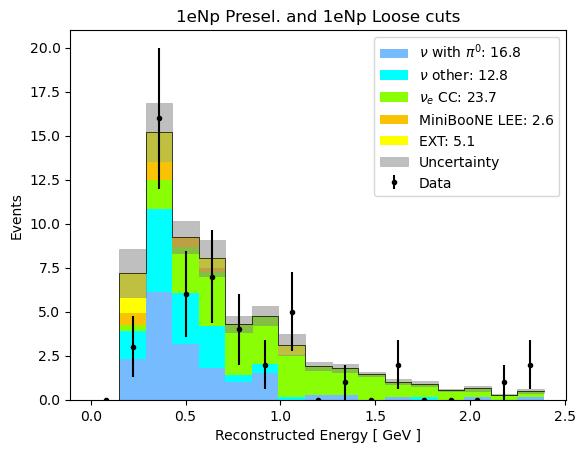

In [139]:
plotter.plot(category_column="paper_category", include_multisim_errors=False, add_ext_error_floor=False)

In [140]:
tot_mc_hist = plotter.get_mc_hist(include_multisim_errors=True)
ext_hist = plotter.get_data_hist(type="ext", add_error_floor=False)
total_pred_hist = tot_mc_hist + ext_hist
total_pred_hist.label = "total"
total_pred_hist.tex_string = "Total Pred."

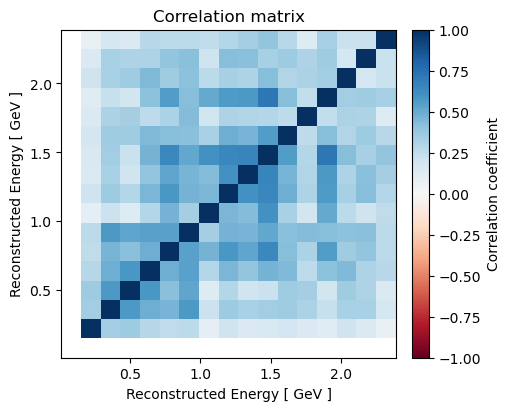

In [141]:
# plot a heatmap of the correlation matrix
import numpy as np
corr_mat = total_pred_hist.corr_matrix
fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
bin_centers = total_pred_hist.bin_centers
X, Y = np.meshgrid(bin_centers, bin_centers)
pc = ax.pcolormesh(X, Y, corr_mat.T, cmap="RdBu", vmin=-1, vmax=1)
ax.set_xlabel(plotter.xtit)
ax.set_ylabel(plotter.xtit)
ax.set_title("Correlation matrix")
cbar = fig.colorbar(pc, ax=ax)
# set label for colorbar
cbar.set_label("Correlation coefficient")
plt.show()


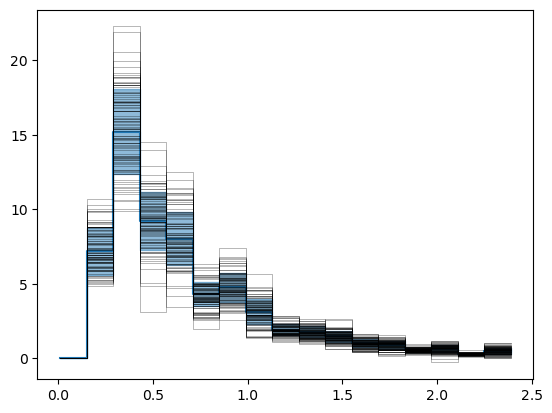

In [142]:
ax = plotter.plot_hist(total_pred_hist)

for i in range(100):
    fluct_hist = total_pred_hist.fluctuate()
    ax = plotter.plot_hist(fluct_hist, ax=ax, color="k", lw=0.5, alpha=0.4, show_errorband=False)
plt.show()

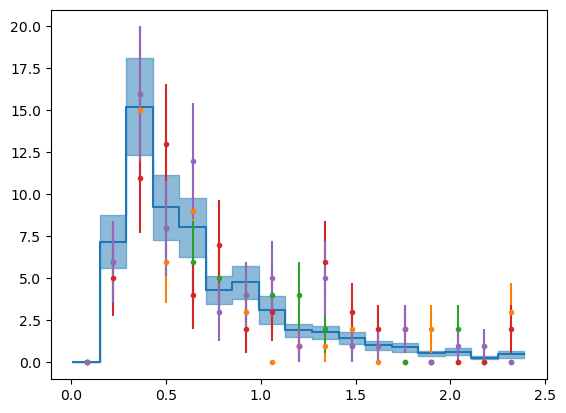

In [145]:
ax = plotter.plot_hist(total_pred_hist)

for i in range(4):
    fluct_hist = total_pred_hist.fluctuate_poisson()
    ax = plotter.plot_hist(fluct_hist, ax=ax, as_errorbars=True)

<AxesSubplot:title={'center':'1eNp Presel. and 1eNp Loose cuts'}, xlabel='Reconstructed Energy [ GeV ]', ylabel='Events'>

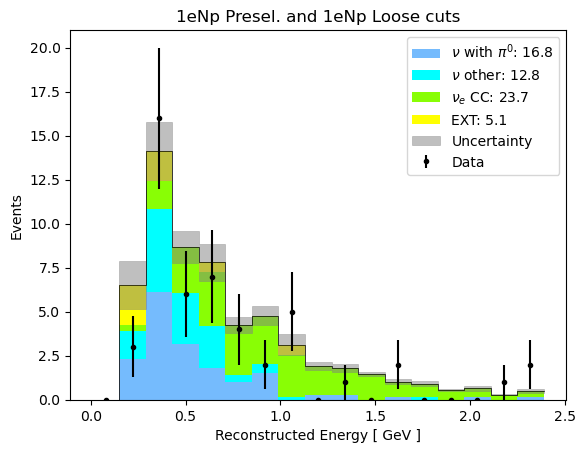

In [146]:
# make a dictionary rundata_h0 that does not include the LEE

# rundata is a dictionary of dataframes, make a new dict excluding the "lee" key
rundata_h0 = {key: rundata[key] for key in rundata.keys() if key != "lee"}
plotter_h0 = rp.Plotter(rundata_h0, selection, preselection, variable="reco_e")
plotter_h0.plot(category_column="paper_category", include_multisim_errors=False, add_ext_error_floor=False)

In [162]:
def test_statistic(observed_hist, hist_h0, hist_h1):
    """Compute the test statistic for the given observed data and hypotheses."""

    n = observed_hist.bin_counts
    mu_h0 = hist_h0.bin_counts
    mu_h1 = hist_h1.bin_counts

    syst_covar = hist_h0.cov_matrix
    # we need to mask off bins where the prediction is empty, otherwise
    # the covariance matrix will be singular
    syst_covar = syst_covar[np.ix_(mu_h0 > 0, mu_h0 > 0)]
    mu_h1 = mu_h1[mu_h0 > 0]
    n = n[mu_h0 > 0]
    mu_h0 = mu_h0[mu_h0 > 0]
    
    # this covariance matrix approximates the Poisson uncertainty
    # The equation listed in the Technote is 
    #     np.diag(3 / (1 / n + 2 / mu_h0))
    # but this leads to a division by zero when n = 0.
    # Rearrange the equation to avoid this gives
    #     np.diag(3 * n * mu_h0 / (mu_h0 + 2 * n))
    stat_covar = np.diag(3 * n * mu_h0 / (mu_h0 + 2 * n))
    total_covar = syst_covar + stat_covar
    covar_inv = np.linalg.inv(total_covar)
    chi2_h0 = np.dot(n - mu_h0, np.dot(covar_inv, n - mu_h0))
    chi2_h1 = np.dot(n - mu_h1, np.dot(covar_inv, n - mu_h1))

    return chi2_h0 - chi2_h1

In [149]:
# the prediction for H1
tot_mc_hist = plotter.get_mc_hist(include_multisim_errors=True)
ext_hist = plotter.get_data_hist(type="ext", add_error_floor=False)
total_pred_hist_h1 = tot_mc_hist + ext_hist
total_pred_hist_h1.label = "total_h1"
total_pred_hist_h1.tex_string = "H1 Pred."

# the prediction for H0
tot_mc_hist_h0 = plotter_h0.get_mc_hist(include_multisim_errors=True)
# the EXT hist is the same
total_pred_hist_h0 = tot_mc_hist_h0 + ext_hist
total_pred_hist_h0.label = "total_h0"
total_pred_hist_h0.tex_string = "H0 Pred."


In [166]:
# create pseudo-data under H0 and calculate test statistic

test_stat_h0 = []
test_stat_h1 = []
for i in range(10000):
    observed_h0 = total_pred_hist_h0.fluctuate_poisson(seed=2*i)
    observed_h1 = total_pred_hist_h1.fluctuate_poisson(seed=2*i+1)  # different seed to avoid correlation

    test_stat_h0.append(test_statistic(observed_h0, total_pred_hist_h0, total_pred_hist_h1))
    test_stat_h1.append(test_statistic(observed_h1, total_pred_hist_h0, total_pred_hist_h1))

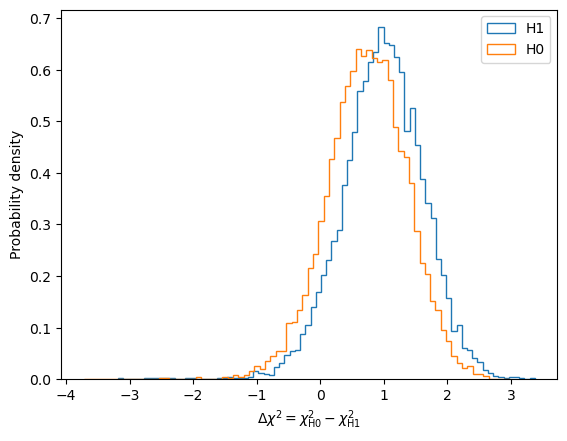

In [171]:
fig, ax = plt.subplots()
ax.hist(test_stat_h1, bins=80, label="H1", histtype="step", density=True)
ax.hist(test_stat_h0, bins=80, label="H0", histtype="step", density=True)
ax.set_xlabel(r"$\Delta \chi^2 = \chi^2_\mathrm{H0} - \chi^2_\mathrm{H1}$")
ax.set_ylabel("Probability density")
ax.legend()
plt.show()